`# Treinamento de Rede Neural Recorrente para classificação`


## Setup

In [92]:
# Drive
from google.colab import drive

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

# Import `matplotlib` and create a helper function to plot graphs:

In [93]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# Retrieving the dataset downloaded from the Google Drive repository

In [94]:
# Conectando ao google drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 avaliacao_da_disciplina_2022_1.xlsx
 bidirectional.png
 bitcoin_wallet_keywords.png
'Colab Notebooks'
 dataset_professora.csv
 dataset_professora.gsheet
 dataset_professora_predicoes.csv
 links_tcc
'Machine learning techniques for emotion detection and sentiment analysis  current state  challenges  and future directions.pdf'
 modelo_rnn_arthur.keras
 monero_wallet_keywords.png
 olist_customers_dataset.csv
 olist_order_reviews_dataset.csv
 olist_preprocessado.csv
 PLN
 RePro.csv
 repro-main.zip
 ReProRnn.csv
 review_repro_preprocessado.csv
 reviews_ptbr.csv
 tcc_analise_sentimento1.xlsx
 tw_pt.csv


# Setup input pipeline
Brazilian E-Commerce Public Dataset by Olist
Welcome! This is a Brazilian ecommerce public dataset of orders made at Olist Store. The dataset has information of 100k orders from 2016 to 2018 made at multiple marketplaces in Brazil. Its features allows viewing an order from multiple dimensions: from order status, price, payment and freight performance to customer location, product attributes and finally reviews written by customers. We also released a geolocation dataset that relates Brazilian zip codes to lat/lng coordinates.


In [100]:
df = pd.read_csv("/content/drive/MyDrive/olist_preprocessado.csv")
print(len(df))

# Vamos fazer um pré-processamento

40950


In [102]:
train_dataset, test_dataset = train_test_split(df, test_size=0.2, random_state=42)
type(train_dataset)

pandas.core.frame.DataFrame

In [103]:
def dataframe_to_dataset(df):
    # Separa colunas
    texts = df["Texto"].values
    labels = df["Label"].values

    # Converte para tf.data.Dataset
    ds = tf.data.Dataset.from_tensor_slices((texts, labels))
    return ds

In [104]:
train_dataset = dataframe_to_dataset(train_dataset)
test_dataset = dataframe_to_dataset(test_dataset)

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))



```
# Initially this returns a dataset of (text, label pairs):
```



In [105]:
for example, label in train_dataset.take(2):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b'Boa compra\r\nRecebi os produtos no prazo\r\n'
label:  1
text:  b'O produto que recebi \xc3\xa9 totalmente diferente a capa do que vende diretamente em um loja de livraria. A capa \xc3\xa9 bem fraca. Porem o impresso \xc3\xa9 bom. '
label:  0


# Next shuffle the data for training and create batches of these (text, label) pairs:

In [106]:
# Prepara os dados com shuffle e batching (mas sem aplicar o encoder aqui!)
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [107]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [108]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy())  # Removido o [:3]

texts:  [b'Fiz a comprar e meu produto foi roubado entrei em contato e ningu\xc3\xa9m resolveu nada e aguardo uma resposta ate hoje '
 b'EXTREMAMENTE SATISFEITA COM O SERVI\xc3\x87O PRESTADO.'
 b'N\xc3\xa3o tenho o que reclamar mais meu produto veio com uma das embalagens rasgada . Mais aten\xc3\xa7\xc3\xa3o da pr\xc3\xb3xima vez ']

labels:  [0 1 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1
 1 0 0 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0]


# Create the text encoder
The raw text loaded needs to be processed before it can be used in a model.
The simplest way to process text for training is using the TextVectorization layer.
This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's .adapt method:

In [109]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE,
    pad_to_max_tokens=True)
encoder.adapt(train_dataset.map(lambda text, label: text))


# The .adapt method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [111]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'o', 'produto', 'e', 'a', 'de', 'do', 'não', 'que',
       'prazo', 'muito', 'entrega', 'com', 'antes', 'chegou', 'recebi',
       'no', 'foi', 'bom'], dtype='<U16')

# Once the vocabulary is set, the layer can encode text into indices.
The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed output_sequence_length):

In [112]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[116,   5,  73,   4,  39,   3,  18,   1, 435,  25, 118,   4, 280,
          1, 101,   4, 172,  33, 168, 199, 186,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0],
       [659, 100,  13,   2,   1, 961,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0],
       [  8, 153,   2,   9, 428,  40,  39,   3,  26,  13,  33, 129,   1,
          1,  40, 467,  24,   1, 160,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0]])

# With the default settings, the process is not completely reversible. There are three main reasons for that:

The default value for preprocessing.TextVectorization's standardize argument is "lower_and_strip_punctuation".
The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [113]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Fiz a comprar e meu produto foi roubado entrei em contato e ningu\xc3\xa9m resolveu nada e aguardo uma resposta ate hoje '
Round-trip:  fiz a comprar e meu produto foi [UNK] entrei em contato e ninguém [UNK] nada e aguardo uma resposta ate hoje           

Original:  b'EXTREMAMENTE SATISFEITA COM O SERVI\xc3\x87O PRESTADO.'
Round-trip:  extremamente satisfeita com o [UNK] prestado                          

Original:  b'N\xc3\xa3o tenho o que reclamar mais meu produto veio com uma das embalagens rasgada . Mais aten\xc3\xa7\xc3\xa3o da pr\xc3\xb3xima vez '
Round-trip:  não tenho o que reclamar mais meu produto veio com uma das [UNK] [UNK] mais atenção da [UNK] vez             



## Create the model

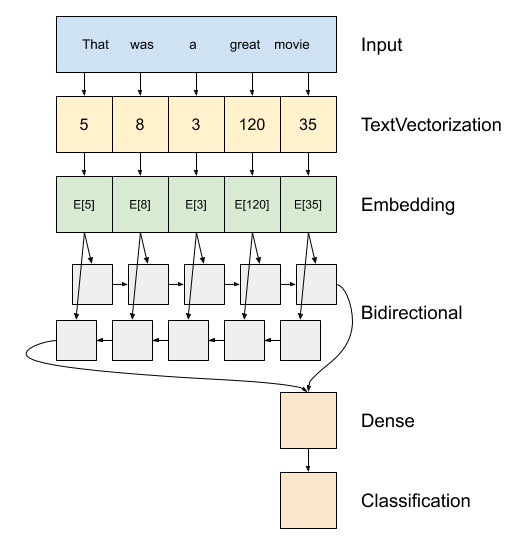

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.

In [114]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [115]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [116]:
# predict on a sample text without padding.

sample_text = ('O filme foi ótimo')
predictions = model.predict(tf.constant([sample_text]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[-0.00917388]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [117]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(tf.constant([sample_text, padding]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 849ms/step
[-0.00917388]


Compile the Keras model to configure the training process:

In [118]:
# Compila o modelo
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [119]:
# Treina o modelo
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 49s 83ms/step - accuracy: 0.5180 - loss: 0.5780 - val_accuracy: 0.8609 - val_loss: 0.3420
Epoch 2/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.8767 - loss: 0.3016 - val_accuracy: 0.8766 - val_loss: 0.3042
Epoch 3/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - accuracy: 0.8931 - loss: 0.2713 - val_accuracy: 0.8807 - val_loss: 0.2955
Epoch 4/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.8991 - loss: 0.2581 - val_accuracy: 0.8823 - val_loss: 0.2907
Epoch 5/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - accuracy: 0.9020 - loss: 0.2527 - val_accuracy: 0.8792 - val_loss: 0.2894
Epoch 6/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - accuracy: 0.9034 - loss: 0.2492 - val_accuracy: 0.8802 - val_loss: 0.2898
Epoch 7/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 101s 80ms/step - accuracy: 0.9061 - loss: 0.2440 - val_accuracy: 0.8823 - val_loss: 0.2897
Epoch 8/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 41s 80ms/step - accuracy: 0.9077 - loss: 0.239

In [120]:
# Avalia o modelo
test_loss, test_acc = model.evaluate(test_dataset)

128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8886 - loss: 0.2840


In [121]:
print('\nTest Loss:', test_loss)
print('Test Accuracy:', test_acc)


Test Loss: 0.2828884422779083
Test Accuracy: 0.8899877667427063


Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [130]:
def interpretar_sentimento(pred):
    if pred >= 0.0:
        return "Sentimento Positivo"
    else:
        return "Sentimento Negativo"

In [137]:
sample_text = ("A captura de contexto ta boa demais da conta")
predictions = model.predict(tf.constant([sample_text]))
print(predictions[0])
print(interpretar_sentimento(predictions[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
[-1.290732]
Sentimento Negativo


## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

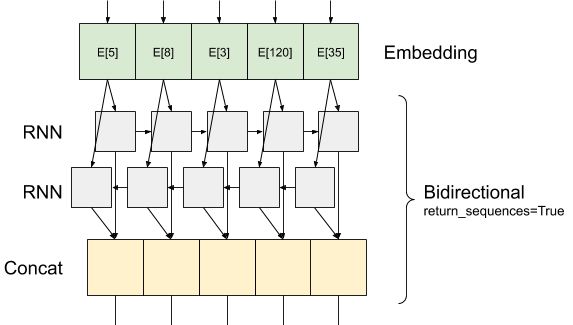

The interesting thing about using an `RNN` with `return_sequences=True` is that the output still has 3-axes, like the input, so it can be passed to another RNN layer, like this:

In [138]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [139]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [140]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 90s 143ms/step - accuracy: 0.5190 - loss: 0.5801 - val_accuracy: 0.8604 - val_loss: 0.3481
Epoch 2/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 74s 144ms/step - accuracy: 0.8802 - loss: 0.3135 - val_accuracy: 0.8792 - val_loss: 0.3102
Epoch 3/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - accuracy: 0.8934 - loss: 0.2794 - val_accuracy: 0.8807 - val_loss: 0.2994
Epoch 4/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 72s 141ms/step - accuracy: 0.8953 - loss: 0.2717 - val_accuracy: 0.8854 - val_loss: 0.2951
Epoch 5/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 73s 142ms/step - accuracy: 0.9013 - loss: 0.2583 - val_accuracy: 0.8828 - val_loss: 0.2933
Epoch 6/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 142s 260ms/step - accuracy: 0.9026 - loss: 0.2581 - val_accuracy: 0.8854 - val_loss: 0.2913
Epoch 7/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 82s 142ms/step - accuracy: 0.9060 - loss: 0.2497 - val_accuracy: 0.8833 - val_loss: 0.2906
Epoch 8/10
512/512 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - accuracy: 0.9079 - loss: 

In [141]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - accuracy: 0.8873 - loss: 0.2850
Test Loss: 0.28386762738227844
Test Accuracy: 0.8893772959709167


In [142]:
# predict on a sample text without padding.

sample_text = ('Particularmente eu não gosto do ensino remoto. Tenho muita dificuldade pra ter foco e algumas aulas chegam a ter aproximadamente, e às vezes ultrapassam, duas horas. É muito tempo para ficar sentado em frente ao computador tendo que absorver o conteúdo. Porém o fato de ter as aulas gravadas e pode assistir posteriormente pra caso tenha perdido a aula ou mesmo para reforçar/revisar o conteúdo é um ponto positivo. As monitorias também ficaram mais &amp;quot;acessíveis&amp;quot; no formato remoto.')
predictions = model.predict(tf.constant([sample_text]))
print(interpretar_sentimento(predictions[0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
Sentimento Negativo


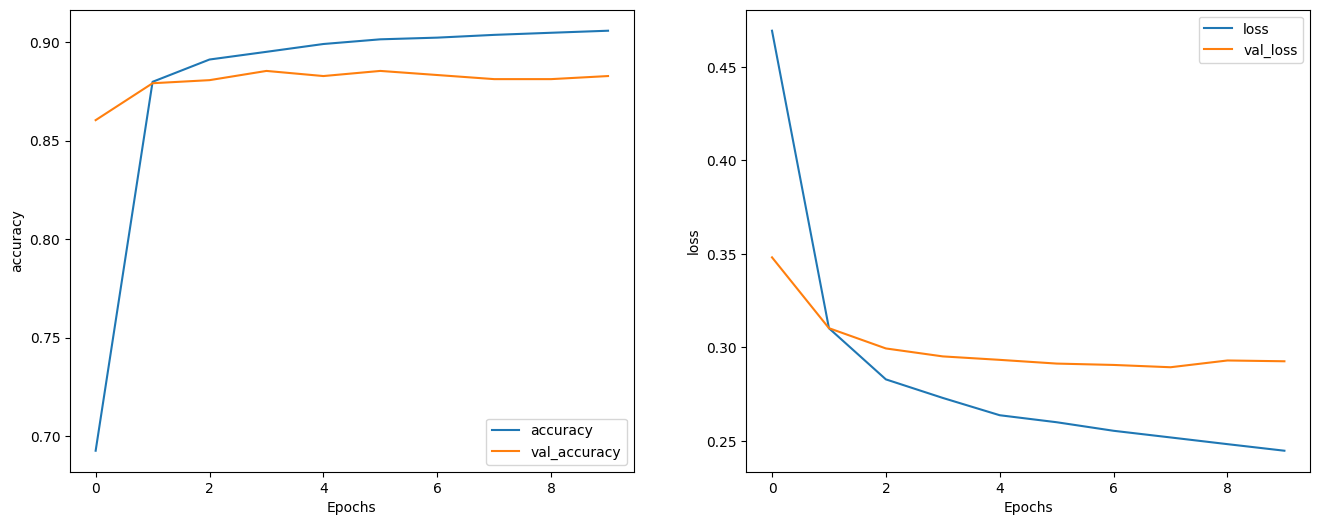

In [143]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

In [144]:
model.save('modelo_rnn_arthur.keras')